In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
import pandas as pd
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [120]:
df = pd.read_csv('two_step_data.txt')

In [121]:
print(df)

                               subject  trial  drift_1  drift_2  drift_3  \
0       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      1    0.743    0.273    0.717   
1       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      2    0.714    0.290    0.712   
2       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      3    0.709    0.346    0.714   
3       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      4    0.732    0.339    0.704   
4       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      5    0.717    0.408    0.722   
...                                ...    ...      ...      ...      ...   
341994  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    196    0.384    0.712    0.479   
341995  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    197    0.373    0.734    0.460   
341996  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    198    0.440    0.748    0.461   
341997  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    199    0.471    0.737    0.468   
341998  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    200    0.487    0.736    0.447   

        drift_4  stage_1_choice  stage_1_rt  transition  stage_2_choice  \
0         0.

In [122]:
from tqdm import tqdm
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

In [123]:
df = df.dropna()

In [124]:
df.reset_index(inplace=True)

In [125]:
subjects = df['subject']

In [126]:
subdata = df.loc[df['subject'] == subjects[1]]

In [127]:
subdata['subject']

0      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
1      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
2      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
3      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
4      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
                    ...              
164    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
165    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
166    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
167    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
168    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
Name: subject, Length: 169, dtype: object

In [128]:
subs = np.unique(df['subject'])

In [129]:
len(subs)

1709

In [130]:
data = []
for s in subs:
    subdata = df.loc[df['subject'] == s]
    
    r = subdata['outcome']
    Y1 = subdata['stage_1_choice'] - 1
    t = subdata['transition']

    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    
    g = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(g)

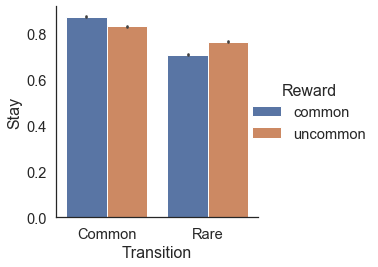

In [131]:
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# Single-Subject Plotting

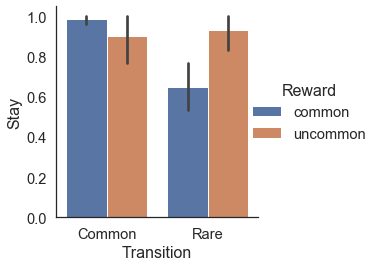

In [132]:
subdata = df.loc[df['subject'] == subs[30]]
# decent looking ones: 30,
    
r = subdata['outcome']
Y1 = subdata['stage_1_choice'] - 1
t = subdata['transition']

y1F = np.array(Y1[1:])
y1B = np.array(Y1[:-1])
    
prev_R = np.roll(r, 1)[1:]
prev_T = np.roll(t, 1)[1:]
stay = np.where(y1B == y1F, 1, 0)
    
data = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])

data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

In [133]:
data

,prev_R,prev_T,Stay
0,rewarded,uncommon,1.0
1,unrewarded,common,1.0
2,rewarded,common,1.0
3,rewarded,uncommon,1.0
4,rewarded,common,1.0
...,...,...,...
190,unrewarded,uncommon,1.0
191,unrewarded,common,0.0
192,rewarded,common,1.0
193,unrewarded,common,0.0


# Cleaning the Data

Reinforcement-Learning Task Exclusion Criteria: Subjects were excluded if they missed more than 10% of trials (Exp1: n=11; Exp2: n=62), responded on the same key on more than 95% of trials on which they registered a response (Exp1: n=46; Exp2: n=85) or had implausibly fast reaction times, i.e. ± 2 standard deviations from the mean (Exp1: n=9; Exp2: n=18).

In [134]:
df

,index,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
0,1,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,2,0.714,0.290,0.712,0.456,1.0,0.444,1.0,1.0,2.0,1.566,1.0
1,2,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,3,0.709,0.346,0.714,0.466,1.0,0.459,0.0,1.0,3.0,0.669,1.0
2,3,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,4,0.732,0.339,0.704,0.386,1.0,0.409,1.0,1.0,2.0,0.491,1.0
3,4,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,5,0.717,0.408,0.722,0.422,1.0,0.356,1.0,1.0,2.0,0.574,1.0
4,5,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,6,0.663,0.455,0.721,0.405,1.0,0.396,1.0,1.0,2.0,0.356,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336445,341994,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,196,0.384,0.712,0.479,0.387,1.0,0.449,0.0,1.0,3.0,0.507,1.0
336446,341995,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,197,0.373,0.734,0.460,0.375,1.0,0.132,1.0,1.0,2.0,0.432,1.0
336447,341996,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,198,0.440,0.748,0.461,0.410,1.0,0.838,0.0,1.0,3.0,0.430,1.0
336448,341997,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,199,0.471,0.737,0.468,0.375,1.0,0.406,0.0,1.0,3.0,0.396,0.0


In [135]:
subs

array(['3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO', '304SM51WA34XCM4E67SL28LY2UCBS4',
       '308Q0PEVB8DPUFML3BKB70KL51T9IW', ...,
       '3ZY8KE4ISJ308KN7JKUG8K04N69VQN', '3ZY8KE4ISJ308KN7JKUG8K04OQDQVR',
       '3ZY8KE4ISJ308KN7JKUG8K04OS9VQW'], dtype=object)

In [136]:
drop_subs = []
for s in subs:
    # check if more than 10% removed by nan removal (i.e. missed trial)
    if len(df.loc[df['subject'] == s]) < 180:
        drop_subs.append(s)

In [137]:
len(drop_subs)

53

In [138]:
# delete all subjects that missed more than 10% of trials
for s in drop_subs:
    df = df.drop(df[df['subject'] == s].index)

In [139]:
len(df)

328671

In [140]:
# find subjects who had implausibly fast reaction times (+- 2 std. dev. from the mean)

In [141]:
s1_RT = np.array(df['stage_1_rt'])
s1_mean = np.mean(s1_RT)
s1_sd = np.std(s1_RT)
s1_upper = s1_mean + (2*s1_sd)
s1_lower = s1_mean - (2*s1_sd)

s2_RT = np.array(df['stage_2_rt'])
s2_mean = np.mean(s2_RT)
s2_sd = np.std(s2_RT)
s2_upper = s2_mean + (2*s2_sd)
s2_lower = s2_mean - (2*s2_sd)

In [142]:
S1rts = df['stage_1_rt']

In [143]:
S1rts.get_value(169)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


2.1959999999999997

In [144]:
drop_rt1s = []
for j in range(len(S1rts)):
    index = df['stage_1_rt'].index[j]
    x = df.get_value(index, 'stage_1_rt')
    if (x > s1_upper) or (x < s1_lower):
        sub_name = df.get_value(index, 'subject')
        drop_rt1s.append(sub_name)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [145]:
d1s = np.unique(drop_rt1s)

In [146]:
len(d1s)

1566

In [147]:
S2rts = df['stage_2_rt']

In [148]:
# for stage 2 reaction times
drop_rt2s = []
for j in range(len(S2rts)):
    index = df['stage_2_rt'].index[j]
    x = df.get_value(index, 'stage_2_rt')
    if (x > s2_upper) or (x < s2_lower):
        sub_name = df.get_value(index, 'subject')
        drop_rt2s.append(sub_name)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [149]:
d2s = np.unique(drop_rt2s)

In [150]:
a = np.concatenate((d1s,d2s),axis=0)

In [151]:
b = np.unique(a)

In [152]:
len(b)

1615

In [153]:
b

array(['304SM51WA34XCM4E67SL28LY2UCBS4', '308Q0PEVB8DPUFML3BKB70KL51T9IW',
       '308Q0PEVB8DPUFML3BKB70KL6Q8I9Z', ...,
       '3ZY8KE4ISJ308KN7JKUG8K04N69VQN', '3ZY8KE4ISJ308KN7JKUG8K04OQDQVR',
       '3ZY8KE4ISJ308KN7JKUG8K04OS9VQW'], dtype='<U30')

In [155]:
# delete all subjects that had ANY improbable reaction times
for subj in b:
    df.drop(df[df['subject'] == subj].index)

In [156]:
df

,index,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
6898,7000,30ZX6P7VF8VAP6LS0KQW9ER7DVVJ2K,1,0.743,0.273,0.717,0.479,1.0,0.531,0.0,1.0,3.0,0.443,0.0
6899,7001,30ZX6P7VF8VAP6LS0KQW9ER7DVVJ2K,2,0.714,0.290,0.712,0.456,1.0,0.398,1.0,2.0,2.0,0.348,0.0
6900,7002,30ZX6P7VF8VAP6LS0KQW9ER7DVVJ2K,3,0.709,0.346,0.714,0.466,1.0,0.334,1.0,1.0,2.0,0.644,1.0
6901,7003,30ZX6P7VF8VAP6LS0KQW9ER7DVVJ2K,4,0.732,0.339,0.704,0.386,1.0,0.453,0.0,2.0,3.0,0.620,0.0
6902,7004,30ZX6P7VF8VAP6LS0KQW9ER7DVVJ2K,5,0.717,0.408,0.722,0.422,1.0,0.422,1.0,1.0,2.0,0.620,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333675,339194,3ZR9AIQJUB9DQEZTIQZEKO99Y0P40Y,196,0.384,0.712,0.479,0.387,2.0,0.332,1.0,2.0,3.0,0.285,0.0
333676,339195,3ZR9AIQJUB9DQEZTIQZEKO99Y0P40Y,197,0.373,0.734,0.460,0.375,2.0,0.295,1.0,1.0,3.0,0.296,0.0
333677,339196,3ZR9AIQJUB9DQEZTIQZEKO99Y0P40Y,198,0.440,0.748,0.461,0.410,1.0,0.261,1.0,2.0,2.0,0.392,1.0
333678,339197,3ZR9AIQJUB9DQEZTIQZEKO99Y0P40Y,199,0.471,0.737,0.468,0.375,1.0,0.329,1.0,2.0,2.0,0.267,1.0


# Stan Testing

In [15]:
import os, pystan
import _pickle as pickle

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

# Single-Subject EA Fit

In [16]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [24]:
subdata = df.loc[df['subject'] == subs[1]]

In [25]:
subdata

,index,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
169,200,304SM51WA34XCM4E67SL28LY2UCBS4,1,0.743,0.273,0.717,0.479,1.0,2.196,1.0,1.0,2.0,1.179,1.0
170,201,304SM51WA34XCM4E67SL28LY2UCBS4,2,0.714,0.290,0.712,0.456,2.0,1.241,1.0,1.0,3.0,1.164,1.0
171,202,304SM51WA34XCM4E67SL28LY2UCBS4,3,0.709,0.346,0.714,0.466,2.0,0.994,1.0,1.0,3.0,0.493,1.0
172,203,304SM51WA34XCM4E67SL28LY2UCBS4,4,0.732,0.339,0.704,0.386,2.0,0.553,1.0,1.0,3.0,0.436,1.0
173,204,304SM51WA34XCM4E67SL28LY2UCBS4,5,0.717,0.408,0.722,0.422,1.0,0.530,0.0,1.0,3.0,0.772,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,395,304SM51WA34XCM4E67SL28LY2UCBS4,196,0.384,0.712,0.479,0.387,2.0,0.520,0.0,2.0,2.0,0.324,0.0
364,396,304SM51WA34XCM4E67SL28LY2UCBS4,197,0.373,0.734,0.460,0.375,2.0,1.593,1.0,2.0,3.0,1.828,1.0
365,397,304SM51WA34XCM4E67SL28LY2UCBS4,198,0.440,0.748,0.461,0.410,2.0,0.538,1.0,2.0,3.0,0.860,1.0
366,398,304SM51WA34XCM4E67SL28LY2UCBS4,199,0.471,0.737,0.468,0.375,2.0,1.138,1.0,2.0,3.0,0.845,0.0


In [36]:
r = subdata['outcome'].astype(int)
Y1 = (subdata['stage_1_choice'] - 1).astype(int)
Y2 = (subdata['stage_2_choice'] - 1).astype(int)
S2 = (subdata["stage_2_state"] - 2).astype(int)
t = subdata['transition'].astype(int)
T = len(subdata)

In [42]:
# NOTE: haven't run whole block yet!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [43]:
StanModel.optimizing(data=dd)

OrderedDict([('eta1_pr', array(-0.33598916)),
             ('eta2_pr', array(-0.36216315)),
             ('beta1_pr', array(-2.11954778)),
             ('beta2_pr', array(-2.78483893)),
             ('w_pr', array(0.5270087)),
             ('p_pr', array(0.00012109)),
             ('eta1', array(0.36831494)),
             ('eta2', array(0.3584855)),
             ('beta1', array(0.33977671)),
             ('beta2', array(0.05080411)),
             ('w', array(0.70104458)),
             ('p', array(0.50004836)),
             ('Y1_pd', array(0.4983963)),
             ('Y2_pd', array(0.49788694))])

In [44]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [45]:
print(StanFit)

Inference for Stan model: anon_model_bffbd421009e6eded8ba0311899b7864.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta1_pr   -1.17    0.03   1.38  -3.17  -2.35  -1.39  -0.12    1.6   2091    1.0
eta2_pr   -0.97    0.03   1.44   -3.7  -1.97  -0.82   0.09   1.53   2466    1.0
beta1_pr  -1.51    0.03   1.13  -3.15  -2.31  -1.82   -0.8   1.13   1768    1.0
beta2_pr  -2.51    0.02    0.9  -3.73  -3.03   -2.7  -2.29    0.1   1669    1.0
w_pr       0.44    0.02   1.02  -1.69  -0.21    0.5   1.12   2.34   4575    1.0
p_pr     2.7e-4    0.01    1.0  -1.96  -0.68 9.9e-3   0.68   1.98   5007    1.0
eta1       0.25  6.1e-3   0.31 6.6e-4 9.4e-3   0.08   0.45   0.95   2500    1.0
eta2        0.3  4.7e-3    0.3 7.6e-5   0.02   0.21   0.54   0.94   4049    1.0
beta1      3.22    0.11   4.88   0.01   0.21   0.69   4.21  17.41   1815    1.0
beta2      

# Single-Subject TDLR Fit

In [49]:
PATH_NAME = '/Users/kierstenmarr/Desktop/TDLR'

In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'TDLR.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [ ]:
StanModel.optimizing(data=dd)

In [52]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [53]:
print(StanFit)

Inference for Stan model: anon_model_7d0126e435e3cc097a74141d06c2b498.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1_pr  -1.93  7.2e-3   0.45  -2.97   -2.2  -1.87  -1.61   -1.2   3948    1.0
beta2_pr  -1.26  2.0e-3   0.14  -1.54  -1.35  -1.26  -1.17   -1.0   4638    1.0
etaC_pr   -0.17  6.1e-3   0.41  -0.93  -0.44   -0.2   0.06   0.71   4604    1.0
etaR_pr   -0.38  7.8e-3   0.56  -1.43  -0.74   -0.4  -0.07   0.85   5163    1.0
beta1      0.76  8.3e-3   0.62   0.03   0.28   0.62   1.09   2.31   5644    1.0
beta2      2.11  7.2e-3   0.49   1.24   1.76   2.08   2.42   3.17   4622    1.0
etaC       0.43  2.1e-3   0.15   0.18   0.33   0.42   0.53   0.76   4824    1.0
etaR       0.37  2.5e-3   0.18   0.08   0.23   0.34   0.47    0.8   5215    1.0
Y1_pd       0.5  7.8e-6 6.0e-4    0.5    0.5    0.5    0.5    0.5   5955    1.0
Y2_pd      

# Single-Subject Hybrid Fit

In [ ]:
PATH_NAME = '/Users/kierstenmarr/Desktop/hybrid'

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'hybrid.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [ ]:
StanModel.optimizing(data=dd)

In [ ]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [ ]:
print(StanFit)

# Single-Subject MB Fit

In [54]:
PATH_NAME = '/Users/kierstenmarr/Desktop/MB'

In [55]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'MB.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [56]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6c8dade991164aefed5354789d4eed NOW.


In [ ]:
StanModel.optimizing(data=dd)

In [ ]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [ ]:
print(StanFit)